#### Analyzing Neural Time Series Data
Python code for Chapter 28 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [19]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import detrend
from statsmodels.tsa.api import VAR
import statsmodels.api as sm

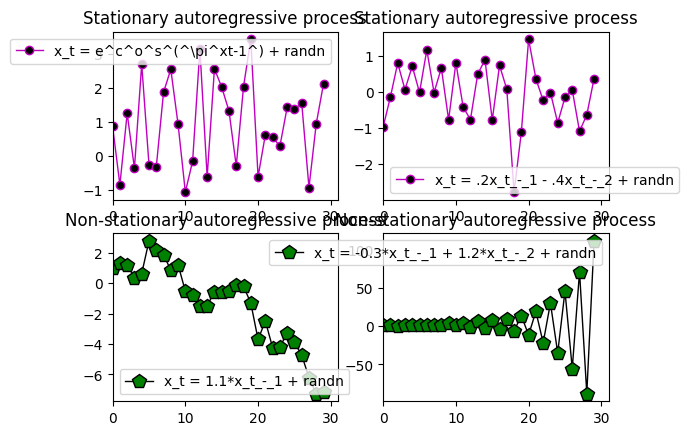

In [2]:
# Figure 28.1

plt.figure()

# - Stationary-like process - #

x = [np.random.randn()]
for i in range(1, 30):
    x.append(np.exp(np.cos(np.pi * x[i-1])) + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.legend(['x_t = e^c^o^s^(^\pi^xt-1^) + randn'])
plt.title('Stationary autoregressive process')

x = [np.random.randn(), np.random.randn()]
for i in range(2, 30):
    x.append(0.2 * x[i-1] - 0.4 * x[i-2] + np.random.randn())

plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.legend(['x_t = .2x_t_-_1 - .4x_t_-_2 + randn'])
plt.title('Stationary autoregressive process')

# - Non-stationary process - #

x = [1]
for i in range(1, 30):
    x.append(1.1 * x[i-1] + np.random.randn())

plt.subplot(223)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.title('Non-stationary autoregressive process')
plt.legend(['x_t = 1.1*x_t_-_1 + randn'])

x = [1, 1.5]
for i in range(2, 30):
    x.append(1.2 * x[i-2] - 0.3 * x[i-1] + np.random.randn())

plt.subplot(224)
plt.plot(x, 'kp-', linewidth=1, markerfacecolor='g', markersize=10)
plt.xlim([0, 31])
plt.legend(['x_t = -0.3*x_t_-_1 + 1.2*x_t_-_2 + randn'])
plt.title('Non-stationary autoregressive process')

plt.show()

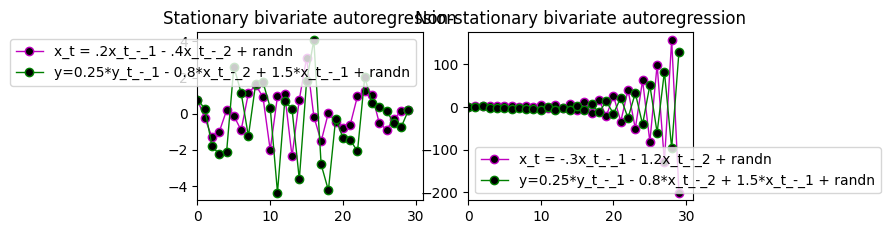

In [3]:
# Figure 28.2

plt.figure()

# - Stationary-like process - #

# define X
x = [np.random.randn(), np.random.randn()]
for i in range(2, 30):
    x.append(0.2 * x[i-1] - 0.4 * x[i-2] + np.random.randn())

# define y
y = [np.random.rand(), np.random.rand()]  # random initial conditions
for i in range(2, len(x)):
    y.append(0.25 * y[i-1] - 0.8 * x[i-2] + 1.5 * x[i-1] + np.random.randn())

plt.subplot(221)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Stationary bivariate autoregression')
plt.legend(['x_t = .2x_t_-_1 - .4x_t_-_2 + randn', 'y=0.25*y_t_-_1 - 0.8*x_t_-_2 + 1.5*x_t_-_1 + randn'])

# - Non-stationary process - #

# define X
x = [1, 1.5]
for i in range(2, 30):
    x.append(1.2 * x[i-2] - 0.3 * x[i-1] + np.random.randn())

# define y
y = [np.random.rand(), np.random.rand()]  # random initial conditions
for i in range(2, len(x)):
    y.append(0.25 * y[i-1] - 1.2 * x[i-2] + np.random.randn())

plt.subplot(222)
plt.plot(x, 'mo-', linewidth=1, markerfacecolor='k', markersize=6)
plt.plot(y, 'go-', linewidth=1, markerfacecolor='k', markersize=6)
plt.xlim([0, 31])
plt.title('Non-stationary bivariate autoregression')
plt.legend(['x_t = -.3x_t_-_1 - 1.2x_t_-_2 + randn', 'y=0.25*y_t_-_1 - 0.8*x_t_-_2 + 1.5*x_t_-_1 + randn'])

plt.show()

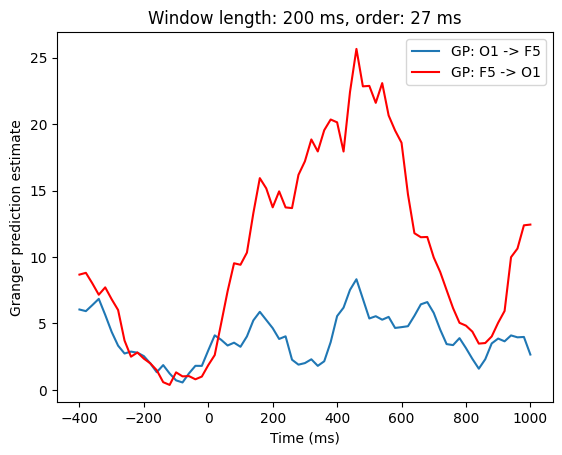

In [31]:
# Figure 28.3

# Load sample EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Assuming the structure is loaded correctly

# Define channels for Granger prediction
chan1name = 'O1'
chan2name = 'F5'

# Granger prediction parameters
timewin = 200  # in ms
order = 27  # in ms

# Temporal down-sample results (but not data!)
times2save = np.arange(-400, 1001, 20)  # in ms

# Convert parameters to indices
timewin_points = round(timewin / (1000 / EEG['srate'][0, 0]))
order_points = round(order / (1000 / EEG['srate'][0, 0]))

# Find the index of those channels
chans = (EEG['chanlocs'][0]['labels'] == chan1name) | (EEG['chanlocs'][0]['labels'] == chan2name)

# Remove ERP from selected electrodes to improve stationarity
eegdata = EEG['data'][chans, :, :] - np.mean(EEG['data'][chans, :, :], axis=2, keepdims=True)

# Convert requested times to indices
times2saveidx = np.array([np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save])

# Initialize
x2y = np.zeros(len(times2save))
y2x = np.zeros(len(times2save))
bic = np.zeros((len(times2save), 15))  # Bayes info criteria (hard-coded to order=15)

# Initialize
x2y = np.zeros(len(times2save))
y2x = np.zeros(len(times2save))
bic = np.zeros((len(times2save), 15))  # Bayes info criteria (hard-coded to order=15)

# Loop over time points
for timei in range(len(times2save)):
    # Data from all trials in this time window
    tempdata = eegdata[:, times2saveidx[timei] - timewin_points//2:times2saveidx[timei] + timewin_points//2, :]
    tempdata = tempdata.reshape(2, -1)  # Combine trials and time points
    
    # Detrend and z-score all data
    tempdata = sm.add_constant(tempdata)
    tempdata = sm.tsa.detrend(tempdata, order=0, axis=1)
    tempdata = (tempdata - np.mean(tempdata, axis=1, keepdims=True)) / np.std(tempdata, axis=1, keepdims=True)
    
    # Fit VAR model
    model = VAR(tempdata.T)
    results = model.fit(maxlags=order_points)
    
    # Compute Granger causality
    gc_res = results.test_causality(0, 1, kind='f')
    y2x[timei] = gc_res.test_statistic
    gc_res = results.test_causality(1, 0, kind='f')
    x2y[timei] = gc_res.test_statistic
    
    # Compute BIC for optimal model order at each time point
    for bici in range(1, bic.shape[1] + 1):
        results = model.fit(maxlags=bici)
        bic[timei, bici - 1] = results.bic

# Plot Granger causality over time
plt.figure()
plt.plot(times2save, x2y, label=f'GP: {chan1name} -> {chan2name}')
plt.plot(times2save, y2x, 'r', label=f'GP: {chan2name} -> {chan1name}')
plt.legend()
plt.title(f'Window length: {timewin} ms, order: {order} ms')
plt.xlabel('Time (ms)')
plt.ylabel('Granger prediction estimate')
plt.show()

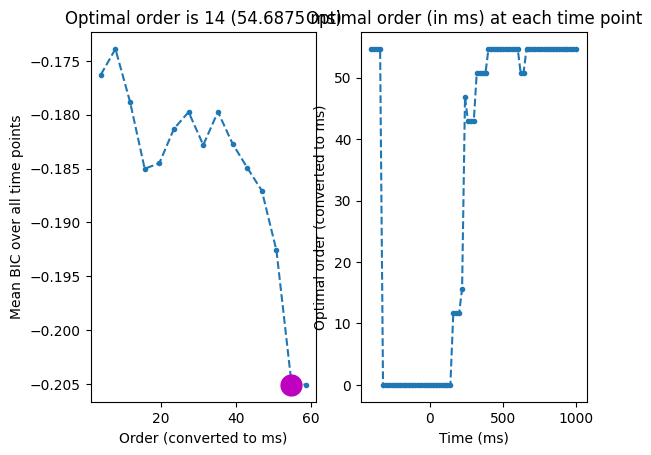

In [32]:
# Figure 28.4

# Plot BIC
plt.figure()

plt.subplot(121)
mean_bic = np.mean(bic, axis=0)
plt.plot((np.arange(1, bic.shape[1] + 1)) * (1000 / EEG['srate'][0, 0]), mean_bic, '--.')
plt.xlabel('Order (converted to ms)')
plt.ylabel('Mean BIC over all time points')

bestbic_idx = np.argmin(mean_bic)
plt.plot(bestbic_idx * (1000 / EEG['srate'][0, 0]), mean_bic[bestbic_idx], 'mo', markersize=15)
plt.title(f'Optimal order is {bestbic_idx} ({bestbic_idx * (1000 / EEG["srate"][0, 0])} ms)')

plt.subplot(122)
bic_per_timepoint = np.argmin(bic, axis=1)
plt.plot(times2save, bic_per_timepoint * (1000 / EEG['srate'][0, 0]), '--.')
plt.xlabel('Time (ms)')
plt.ylabel('Optimal order (converted to ms)')
plt.title('Optimal order (in ms) at each time point')

plt.show()

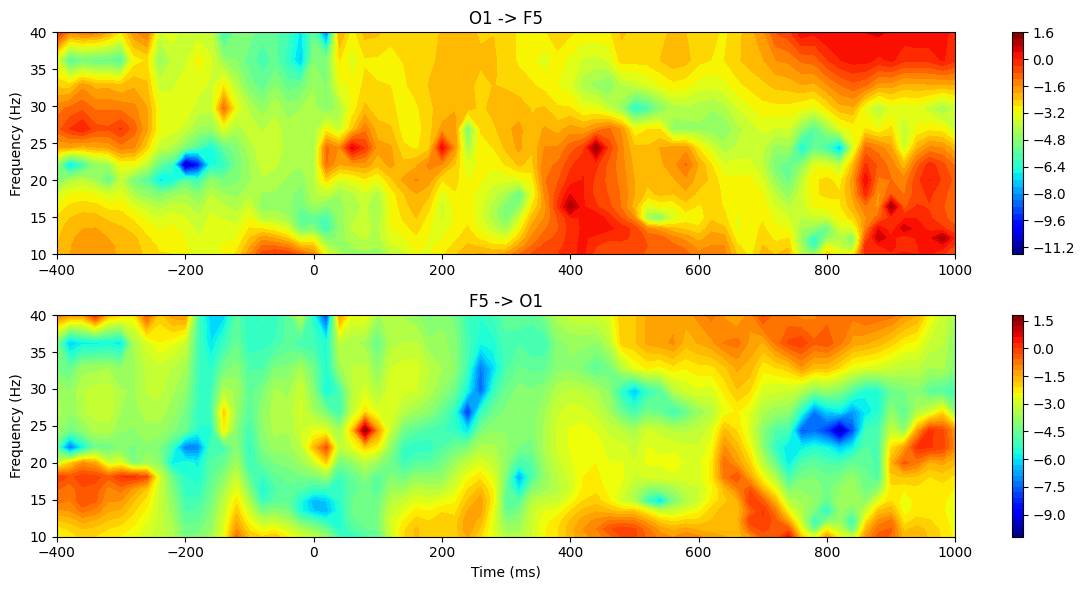

In [33]:
# Define frequency range
min_freq = 10  # in Hz, using a minimum of 10 Hz because of 200-ms window
max_freq = 40
order_points = 15
frequencies = np.logspace(np.log10(min_freq), np.log10(max_freq), 15)

# Initialize
tf_granger = np.zeros((2, len(frequencies), len(times2save)))

# Loop over time points
for timei in range(len(times2save)):
    # Data from all trials in this time window
    tempdata = eegdata[:, times2saveidx[timei] - timewin_points//2:times2saveidx[timei] + timewin_points//2, :]
    tempdata = tempdata.reshape(2, -1)  # Combine trials and time points
    
    # Detrend and z-score all data
    tempdata = detrend(tempdata, axis=1, type='constant')
    tempdata = (tempdata - np.mean(tempdata, axis=1, keepdims=True)) / np.std(tempdata, axis=1, keepdims=True)
    
    # Fit VAR model
    model = VAR(tempdata.T)
    results = model.fit(maxlags=order_points)
    
    # Compute Granger causality for each frequency
    for fi, freq in enumerate(frequencies):
        # Compute the Fourier transform of the VAR coefficients
        A_freq = np.zeros((2, 2), dtype=complex)
        for k in range(1, order_points + 1):
            A_freq += results.coefs[k-1] * np.exp(-1j * 2 * np.pi * freq * k / EEG['srate'][0, 0])
        
        # Compute the spectral density matrix
        S_freq = np.linalg.inv(np.eye(2) - A_freq) @ results.sigma_u @ np.linalg.inv(np.eye(2) - A_freq).conj().T
        
        # Compute Granger causality
        tf_granger[0, fi, timei] = np.log(np.abs(S_freq[1, 1]) / np.abs(S_freq[1, 1] - (np.linalg.inv(A_freq)[1, 0])**2 * results.sigma_u[0, 0]))
        tf_granger[1, fi, timei] = np.log(np.abs(S_freq[0, 0]) / np.abs(S_freq[0, 0] - (np.linalg.inv(A_freq)[0, 1])**2 * results.sigma_u[1, 1]))

# Plot time-frequency Granger causality
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.contourf(times2save, frequencies, tf_granger[0, :, :], 40, cmap='jet')
plt.colorbar()
plt.title(f'{chan1name} -> {chan2name}')
plt.ylabel('Frequency (Hz)')

plt.subplot(212)
plt.contourf(times2save, frequencies, tf_granger[1, :, :], 40, cmap='jet')
plt.colorbar()
plt.title(f'{chan2name} -> {chan1name}')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()
plt.show()

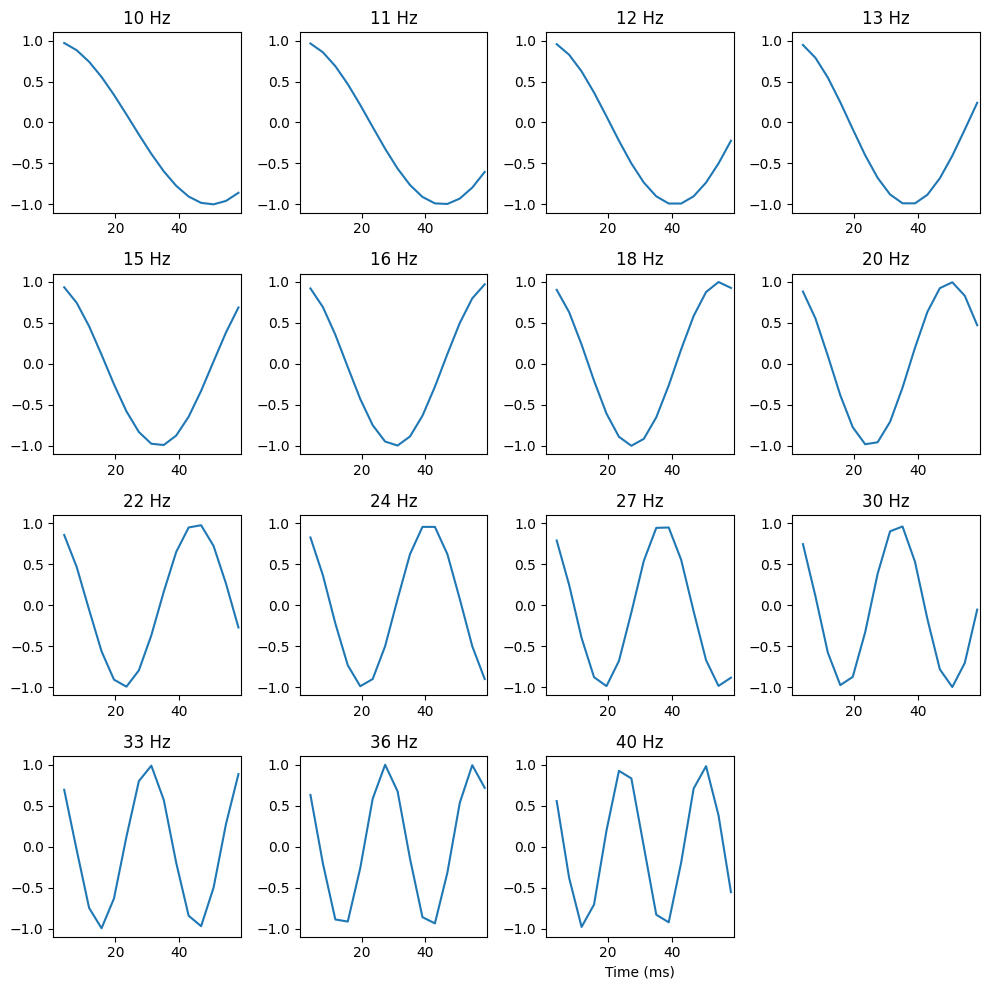

In [34]:
# Figure 28.6

# Plot of cycles per frequency
plt.figure(figsize=(10, 10))
for fi, freq in enumerate(frequencies):
    plt.subplot(4, 4, fi+1)
    cycles = np.real(np.exp(-1j * np.arange(1, order_points+1) * 2 * np.pi * freq / EEG['srate'][0, 0]))
    plt.plot((np.arange(1, order_points+1)) * (1000 / EEG['srate'][0, 0]), cycles)
    plt.xlim([0.5, 1.015 * order_points * (1000 / EEG['srate'][0, 0])])
    plt.ylim([-1.1, 1.1])
    plt.title(f'{round(freq)} Hz')
plt.xlabel('Time (ms)')
plt.tight_layout()
plt.show()

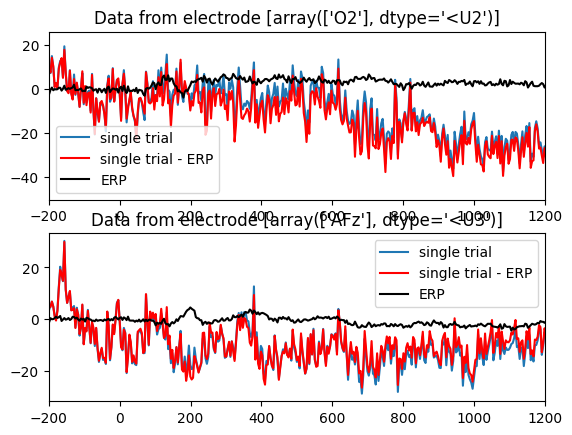

In [44]:
# Figure 28.7

plt.figure()

# Select electrode to plot
electrode2plot = EEG['chanlocs'][0]['labels']=='O2'
erp = np.mean(EEG['data'][electrode2plot, :, :], axis=2)
plt.subplot(211)
plt.plot(EEG['times'][0], EEG['data'][electrode2plot, :, 0][0], label='single trial')
plt.plot(EEG['times'][0], EEG['data'][electrode2plot, :, 0][0] - erp[0], 'r', label='single trial - ERP')
plt.plot(EEG['times'][0], erp[0], 'k', label='ERP')
plt.xlim([-200, 1200])
plt.legend()
plt.title(f'Data from electrode {EEG["chanlocs"][0]["labels"][electrode2plot]}')

# Select another electrode to plot
electrode2plot = EEG['chanlocs'][0]['labels']=='AFz'
erp = np.mean(EEG['data'][electrode2plot, :, :], axis=2)
plt.subplot(212)
plt.plot(EEG['times'][0], EEG['data'][electrode2plot, :, 0][0], label='single trial')
plt.plot(EEG['times'][0], EEG['data'][electrode2plot, :, 0][0] - erp[0], 'r', label='single trial - ERP')
plt.plot(EEG['times'][0], erp[0], 'k', label='ERP')
plt.xlim([-200, 1200])
plt.legend()
plt.title(f'Data from electrode {EEG["chanlocs"][0]["labels"][electrode2plot]}')

plt.show()

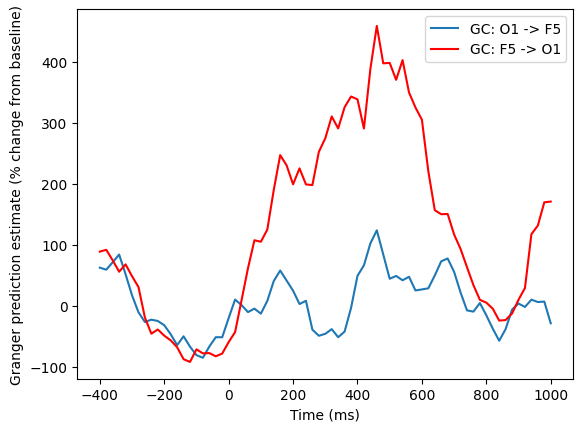

In [45]:
# Figure 28.8

# Baseline time window
baseline_period = [-400, -100]

# Convert to indices
baseidx = [np.argmin(np.abs(times2save - bp)) for bp in baseline_period]

# Plot as % changes from baseline
plt.figure()
plt.plot(times2save, 100 * (x2y - np.mean(x2y[baseidx[0]:baseidx[1]])) / np.mean(x2y[baseidx[0]:baseidx[1]]), label=f'GC: {chan1name} -> {chan2name}')
plt.plot(times2save, 100 * (y2x - np.mean(y2x[baseidx[0]:baseidx[1]])) / np.mean(y2x[baseidx[0]:baseidx[1]]), 'r', label=f'GC: {chan2name} -> {chan1name}')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Granger prediction estimate (% change from baseline)')

plt.show()

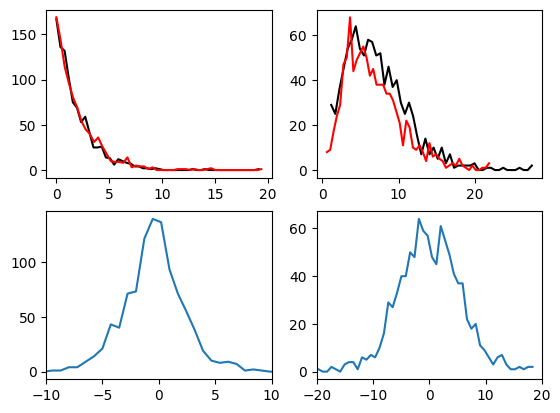

In [46]:
# Figure 28.9

from scipy.stats import chi2

plt.figure()

# Generate two chi-square distributed random numbers
d1 = chi2.rvs(2, size=1000)
d2 = chi2.rvs(2, size=1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1 - d2, bins=50)

plt.subplot(221)
plt.plot(x1[:-1], y1, 'k')
plt.plot(x2[:-1], y2, 'r')

plt.subplot(223)
plt.plot(x3[:-1], y3)
plt.xlim([-10, 10])

# Once more, with new distributions
d1 = chi2.rvs(7, size=1000)
d2 = chi2.rvs(7, size=1000)

# Get histograms
y1, x1 = np.histogram(d1, bins=50)
y2, x2 = np.histogram(d2, bins=50)
y3, x3 = np.histogram(d1 - d2, bins=50)

plt.subplot(222)
plt.plot(x1[:-1], y1, 'k')
plt.plot(x2[:-1], y2, 'r')

plt.subplot(224)
plt.plot(x3[:-1], y3)
plt.xlim([-20, 20])

plt.show()